In [1]:
# importing te necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# type the location of the cloned github folder on your machine here and add "\data" in the end
path = (r"C:\Users\nmart\OneDrive - fs-students.de\Dokumente\Office\FS\S1\Data Analytics in Business\code_daib\undernourishment_prediction\data")

In [21]:
# importing the dataset and making some adjustments so it works with the model and the time series split
df = pd.read_csv(path + r"\combined_dataset_temp.csv").drop(columns=["Unnamed: 0", "GAUL", "M49"])
df["Casualties"] = df["Casualties"].fillna(0)
df["Undernourishment (%)"] = df["Undernourishment (%)"].replace({"<2.5": 0})
df["Undernourishment (%)"] = pd.to_numeric(df["Undernourishment (%)"]).shift(periods=-1)
df = df.drop(index=df.index[19::20])
df = df.dropna().sort_values("Year")

In [4]:
# Creating training and test data, but not randomly splitting (roughly two years get excluded)
df_model = df.drop(columns=["Area", "Year"])

y_train = df_model["Undernourishment (%)"].iloc[:-310]
X_train = df_model[df.columns.drop("Undernourishment (%)")].iloc[:-310]

y_test = df_model["Undernourishment (%)"].iloc[-310:]
X_test = df_model[df.columns.drop("Undernourishment (%)")].iloc[-310:]

In [5]:
# model performance on training data
tscv = TimeSeriesSplit(n_splits=5, test_size=310)
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=tscv)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.75 accuracy with a standard deviation of 0.02


In [6]:
# Compare with normal split, to see how much trend there actually is in the data
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.80 accuracy with a standard deviation of 0.06


In [7]:
# using the best model to predict the test data, after fitting it on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

print("model score on training data:",model.score(X_train, y_train))
print("model score on test data:",model.score(X_test, y_test))

model score on training data: 0.9844623230398063
model score on test data: 0.7670209844790639


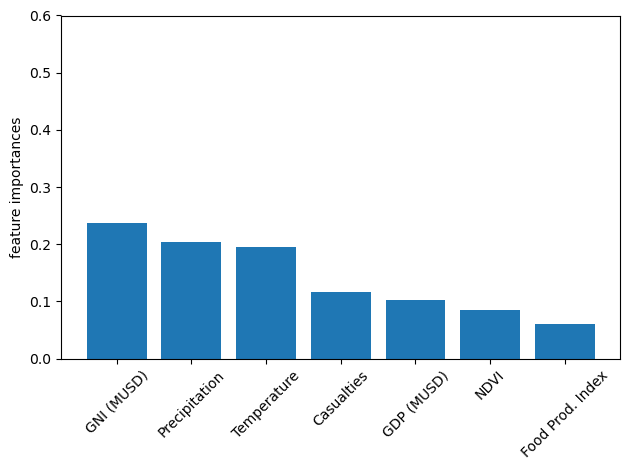

In [8]:
# Looking at the influence of the different features
feature_names = [x for x in X_train.columns]
importances = model.feature_importances_
sorted_lists = sorted(zip(importances, feature_names), reverse=True)
importances, feature_names = [x[0] for x in sorted_lists], \
    [x[1] for x in sorted_lists]

plt.figure()
plt.bar(feature_names, importances)
plt.xticks(rotation=45)
plt.ylabel("feature importances")
plt.ylim(0,0.6)
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

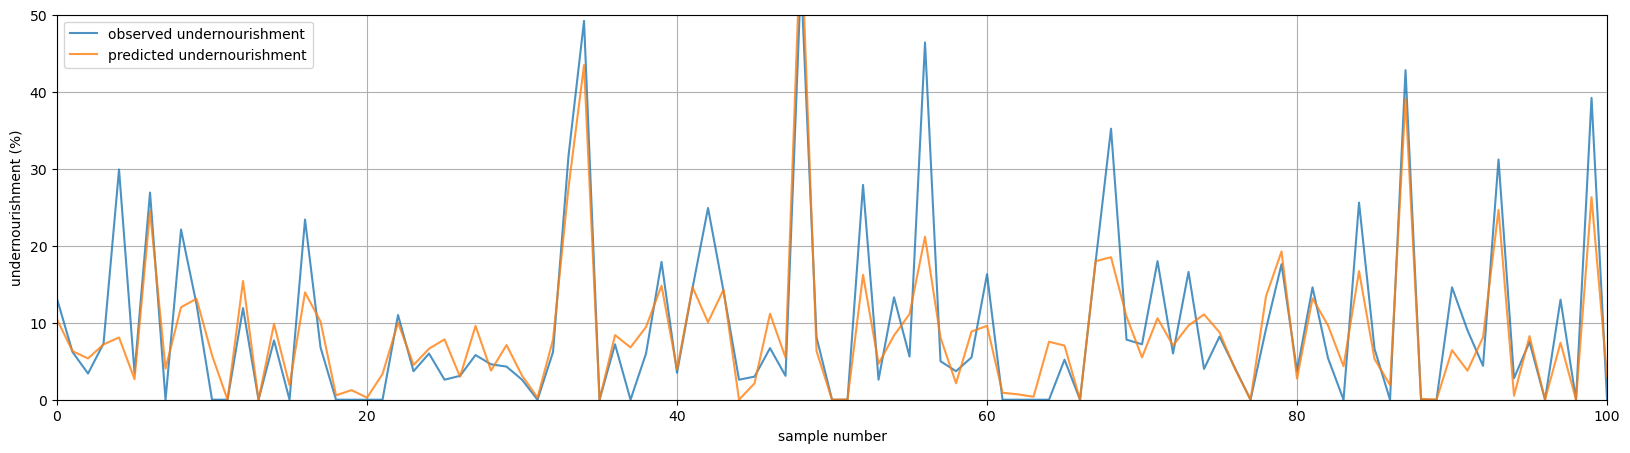

In [9]:
# plotting actual vs predicted undernourishment
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(y_test.to_numpy(), alpha=0.8, label="observed undernourishment")
plt.plot(model.predict(X_test),alpha=0.8, label="predicted undernourishment")
plt.xlabel("sample number")
plt.ylabel("undernourishment (%)")
plt.legend(loc="upper left")
plt.xlim(0,100)
plt.ylim(0,50)
plt.grid()
plt.show()

In [26]:
# saving the prediction data for each country
df_result = df[["Area", "Year", "Undernourishment (%)"]].iloc[-310:]
df_result["Pred Undernourishment"] = model.predict(X_test)
df_result = df_result.sort_values("Area").rename(columns={"Undernourishment (%)": "Real Undernourishment"})
df_result.to_csv(path + r"\future_pred_result.csv")